In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from google.colab import drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Paths
data_dir = '/content/drive/My Drive/ML1_Project/Textual_Dataset'
model_save_path = '/content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5'
label_encoder_path = '/content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNet_Label_Encoder.pkl'

In [4]:
# Image & training config
img_height, img_width = 224, 224
batch_size = 32
epochs = 50

In [5]:
# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    rotation_range=30,
    zoom_range=0.3,
    shear_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
# Data generators
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2128 images belonging to 2 classes.
Found 911 images belonging to 2 classes.


In [7]:
# Save label encoder
label_map = train_generator.class_indices
with open(label_encoder_path, 'wb') as f:
    pickle.dump(label_map, f)

In [8]:
# Build improved MobileNetV2 model
def build_mobilenet_model(input_shape, num_classes):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)

    # Fine-tune top layers
    for layer in base_model.layers[:-50]:
        layer.trainable = False
    for layer in base_model.layers[-50:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create model
model = build_mobilenet_model((img_height, img_width, 3), train_generator.num_classes)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, verbose=1)

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stop, lr_scheduler, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9086 - loss: 4.3464
Epoch 1: val_loss improved from inf to 3.95941, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 663s 10s/step - accuracy: 0.9094 - loss: 4.3424 - val_accuracy: 0.9012 - val_loss: 3.9594 - learning_rate: 1.0000e-04
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.9912 - loss: 3.5196
Epoch 2: val_loss improved from 3.95941 to 3.12770, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 52s 785ms/step - accuracy: 0.9913 - loss: 3.5173 - val_accuracy: 0.9627 - val_loss: 3.1277 - learning_rate: 1.0000e-04
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.9979 - loss: 2.8860
Epoch 3: val_loss improved from 3.12770 to 2.52779, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 54s 803ms/step - accuracy: 0.9978 - loss: 2.8841 - val_accuracy: 0.9791 - val_loss: 2.5278 - learning_rate: 1.0000e-04
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.9940 - loss: 2.3638
Epoch 4: val_loss improved from 2.52779 to 2.22050, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 52s 787ms/step - accuracy: 0.9940 - loss: 2.3620 - val_accuracy: 0.9232 - val_loss: 2.2205 - learning_rate: 1.0000e-04
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.9970 - loss: 1.9095
Epoch 5: val_loss improved from 2.22050 to 1.74849, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 53s 792ms/step - accuracy: 0.9970 - loss: 1.9081 - val_accuracy: 0.9561 - val_loss: 1.7485 - learning_rate: 1.0000e-04
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.9986 - loss: 1.5376
Epoch 6: val_loss improved from 1.74849 to 1.39624, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 54s 803ms/step - accuracy: 0.9986 - loss: 1.5365 - val_accuracy: 0.9649 - val_loss: 1.3962 - learning_rate: 1.0000e-04
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.9999 - loss: 1.2335
Epoch 7: val_loss improved from 1.39624 to 1.12102, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 53s 796ms/step - accuracy: 0.9999 - loss: 1.2326 - val_accuracy: 0.9715 - val_loss: 1.1210 - learning_rate: 1.0000e-04
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.9990 - loss: 0.9885
Epoch 8: val_loss improved from 1.12102 to 0.98518, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 53s 788ms/step - accuracy: 0.9990 - loss: 0.9877 - val_accuracy: 0.9495 - val_loss: 0.9852 - learning_rate: 1.0000e-04
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.9979 - loss: 0.7874
Epoch 9: val_loss improved from 0.98518 to 0.72807, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 53s 793ms/step - accuracy: 0.9979 - loss: 0.7868 - val_accuracy: 0.9780 - val_loss: 0.7281 - learning_rate: 1.0000e-04
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.9969 - loss: 0.6299
Epoch 10: val_loss improved from 0.72807 to 0.59172, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 53s 790ms/step - accuracy: 0.9969 - loss: 0.6294 - val_accuracy: 0.9780 - val_loss: 0.5917 - learning_rate: 1.0000e-04
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.9998 - loss: 0.4991
Epoch 11: val_loss improved from 0.59172 to 0.50800, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 81s 783ms/step - accuracy: 0.9998 - loss: 0.4987 - val_accuracy: 0.9715 - val_loss: 0.5080 - learning_rate: 1.0000e-04
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 1.0000 - loss: 0.3980
Epoch 12: val_loss improved from 0.50800 to 0.41350, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 82s 790ms/step - accuracy: 1.0000 - loss: 0.3977 - val_accuracy: 0.9769 - val_loss: 0.4135 - learning_rate: 1.0000e-04
Epoch 13/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.9994 - loss: 0.3173
Epoch 13: val_loss improved from 0.41350 to 0.28605, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 52s 776ms/step - accuracy: 0.9994 - loss: 0.3170 - val_accuracy: 0.9923 - val_loss: 0.2860 - learning_rate: 1.0000e-04
Epoch 14/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 1.0000 - loss: 0.2513
Epoch 14: val_loss improved from 0.28605 to 0.22988, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 52s 781ms/step - accuracy: 1.0000 - loss: 0.2511 - val_accuracy: 0.9923 - val_loss: 0.2299 - learning_rate: 1.0000e-04
Epoch 15/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9990 - loss: 0.2038
Epoch 15: val_loss improved from 0.22988 to 0.17558, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 81s 775ms/step - accuracy: 0.9990 - loss: 0.2036 - val_accuracy: 0.9967 - val_loss: 0.1756 - learning_rate: 1.0000e-04
Epoch 16/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 1.0000 - loss: 0.1606
Epoch 16: val_loss improved from 0.17558 to 0.14212, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 54s 808ms/step - accuracy: 1.0000 - loss: 0.1605 - val_accuracy: 0.9967 - val_loss: 0.1421 - learning_rate: 1.0000e-04
Epoch 17/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.9990 - loss: 0.1287
Epoch 17: val_loss did not improve from 0.14212
67/67 ━━━━━━━━━━━━━━━━━━━━ 52s 775ms/step - accuracy: 0.9990 - loss: 0.1286 - val_accuracy: 0.9791 - val_loss: 0.1540 - learning_rate: 1.0000e-04
Epoch 18/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.9989 - loss: 0.1043
Epoch 18: val_loss improved from 0.14212 to 0.10753, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 52s 777ms/step - accuracy: 0.9989 - loss: 0.1042 - val_accuracy: 0.9923 - val_loss: 0.1075 - learning_rate: 1.0000e-04
Epoch 19/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 1.0000 - loss: 0.0819
Epoch 19: val_loss improved from 0.10753 to 0.08858, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 53s 790ms/step - accuracy: 1.0000 - loss: 0.0818 - val_accuracy: 0.9945 - val_loss: 0.0886 - learning_rate: 1.0000e-04
Epoch 20/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.9999 - loss: 0.0657
Epoch 20: val_loss improved from 0.08858 to 0.08477, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 57s 849ms/step - accuracy: 0.9999 - loss: 0.0656 - val_accuracy: 0.9923 - val_loss: 0.0848 - learning_rate: 1.0000e-04
Epoch 21/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.9990 - loss: 0.0550
Epoch 21: val_loss improved from 0.08477 to 0.05595, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 59s 878ms/step - accuracy: 0.9990 - loss: 0.0550 - val_accuracy: 0.9945 - val_loss: 0.0559 - learning_rate: 1.0000e-04
Epoch 22/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 1.0000 - loss: 0.0420
Epoch 22: val_loss improved from 0.05595 to 0.05008, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 75s 775ms/step - accuracy: 1.0000 - loss: 0.0420 - val_accuracy: 0.9945 - val_loss: 0.0501 - learning_rate: 1.0000e-04
Epoch 23/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 1.0000 - loss: 0.0337
Epoch 23: val_loss improved from 0.05008 to 0.04099, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 53s 798ms/step - accuracy: 1.0000 - loss: 0.0337 - val_accuracy: 0.9945 - val_loss: 0.0410 - learning_rate: 1.0000e-04
Epoch 24/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 1.0000 - loss: 0.0270
Epoch 24: val_loss improved from 0.04099 to 0.03827, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 53s 794ms/step - accuracy: 1.0000 - loss: 0.0269 - val_accuracy: 0.9945 - val_loss: 0.0383 - learning_rate: 1.0000e-04
Epoch 25/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.9997 - loss: 0.0225
Epoch 25: val_loss did not improve from 0.03827
67/67 ━━━━━━━━━━━━━━━━━━━━ 51s 766ms/step - accuracy: 0.9997 - loss: 0.0225 - val_accuracy: 0.9879 - val_loss: 0.0509 - learning_rate: 1.0000e-04
Epoch 26/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.9991 - loss: 0.0196
Epoch 26: val_loss improved from 0.03827 to 0.03009, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 53s 797ms/step - accuracy: 0.9991 - loss: 0.0196 - val_accuracy: 0.9956 - val_loss: 0.0301 - learning_rate: 1.0000e-04
Epoch 27/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.9991 - loss: 0.0185
Epoch 27: val_loss did not improve from 0.03009
67/67 ━━━━━━━━━━━━━━━━━━━━ 51s 772ms/step - accuracy: 0.9991 - loss: 0.0185 - val_accuracy: 0.9791 - val_loss: 0.0892 - learning_rate: 1.0000e-04
Epoch 28/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.9979 - loss: 0.0183
Epoch 28: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 28: val_loss did not improve from 0.03009
67/67 ━━━━━━━━━━━━━━━━━━━━ 51s 767ms/step - accuracy: 0.9979 - loss: 0.0183 - val_accuracy: 0.9923 - val_loss: 0.0316 - learning_rate: 1.0000e-04
Epoch 29/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.9998 - loss: 0.0122
Epoch 29: val_loss improved from 0.03009 to 0.01667, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/Mobil

67/67 ━━━━━━━━━━━━━━━━━━━━ 52s 781ms/step - accuracy: 0.9998 - loss: 0.0122 - val_accuracy: 0.9978 - val_loss: 0.0167 - learning_rate: 5.0000e-05
Epoch 30/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.9993 - loss: 0.0121
Epoch 30: val_loss improved from 0.01667 to 0.01097, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 53s 793ms/step - accuracy: 0.9993 - loss: 0.0121 - val_accuracy: 1.0000 - val_loss: 0.0110 - learning_rate: 5.0000e-05
Epoch 31/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.9999 - loss: 0.0098
Epoch 31: val_loss did not improve from 0.01097
67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 840ms/step - accuracy: 0.9999 - loss: 0.0098 - val_accuracy: 0.9989 - val_loss: 0.0125 - learning_rate: 5.0000e-05
Epoch 32/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.9997 - loss: 0.0110
Epoch 32: val_loss improved from 0.01097 to 0.00857, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 53s 791ms/step - accuracy: 0.9997 - loss: 0.0110 - val_accuracy: 1.0000 - val_loss: 0.0086 - learning_rate: 5.0000e-05
Epoch 33/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.9992 - loss: 0.0090
Epoch 33: val_loss did not improve from 0.00857
67/67 ━━━━━━━━━━━━━━━━━━━━ 51s 759ms/step - accuracy: 0.9992 - loss: 0.0090 - val_accuracy: 1.0000 - val_loss: 0.0092 - learning_rate: 5.0000e-05
Epoch 34/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 1.0000 - loss: 0.0076
Epoch 34: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 34: val_loss did not improve from 0.00857
67/67 ━━━━━━━━━━━━━━━━━━━━ 55s 828ms/step - accuracy: 1.0000 - loss: 0.0076 - val_accuracy: 0.9989 - val_loss: 0.0087 - learning_rate: 5.0000e-05
Epoch 35/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 1.0000 - loss: 0.0066
Epoch 35: val_loss improved from 0.00857 to 0.00646, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/Mobil

67/67 ━━━━━━━━━━━━━━━━━━━━ 52s 775ms/step - accuracy: 1.0000 - loss: 0.0066 - val_accuracy: 1.0000 - val_loss: 0.0065 - learning_rate: 2.5000e-05
Epoch 36/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 1.0000 - loss: 0.0062
Epoch 36: val_loss did not improve from 0.00646
67/67 ━━━━━━━━━━━━━━━━━━━━ 51s 769ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 0.9989 - val_loss: 0.0086 - learning_rate: 2.5000e-05
Epoch 37/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.9998 - loss: 0.0064
Epoch 37: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 37: val_loss did not improve from 0.00646
67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 840ms/step - accuracy: 0.9998 - loss: 0.0064 - val_accuracy: 1.0000 - val_loss: 0.0066 - learning_rate: 2.5000e-05
Epoch 38/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.9997 - loss: 0.0059
Epoch 38: val_loss improved from 0.00646 to 0.00621, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/Mobil

67/67 ━━━━━━━━━━━━━━━━━━━━ 53s 794ms/step - accuracy: 0.9997 - loss: 0.0059 - val_accuracy: 1.0000 - val_loss: 0.0062 - learning_rate: 1.2500e-05
Epoch 39/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.9994 - loss: 0.0061
Epoch 39: val_loss did not improve from 0.00621
67/67 ━━━━━━━━━━━━━━━━━━━━ 52s 777ms/step - accuracy: 0.9994 - loss: 0.0061 - val_accuracy: 0.9989 - val_loss: 0.0116 - learning_rate: 1.2500e-05
Epoch 40/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 1.0000 - loss: 0.0061
Epoch 40: val_loss improved from 0.00621 to 0.00609, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 57s 860ms/step - accuracy: 1.0000 - loss: 0.0061 - val_accuracy: 1.0000 - val_loss: 0.0061 - learning_rate: 1.2500e-05
Epoch 41/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 1.0000 - loss: 0.0055
Epoch 41: val_loss did not improve from 0.00609
67/67 ━━━━━━━━━━━━━━━━━━━━ 51s 763ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.9989 - val_loss: 0.0064 - learning_rate: 1.2500e-05
Epoch 42/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.9996 - loss: 0.0089
Epoch 42: val_loss improved from 0.00609 to 0.00487, saving model to /content/drive/My Drive/ML1_Project/MobileNet/Model6/MobileNetBest_Model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 53s 806ms/step - accuracy: 0.9996 - loss: 0.0089 - val_accuracy: 1.0000 - val_loss: 0.0049 - learning_rate: 1.2500e-05
Epoch 43/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 1.0000 - loss: 0.0053
Epoch 43: val_loss did not improve from 0.00487
67/67 ━━━━━━━━━━━━━━━━━━━━ 51s 768ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 1.0000 - val_loss: 0.0054 - learning_rate: 1.2500e-05
Epoch 44/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 1.0000 - loss: 0.0049
Epoch 44: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 44: val_loss did not improve from 0.00487
67/67 ━━━━━━━━━━━━━━━━━━━━ 55s 830ms/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 0.9989 - val_loss: 0.0064 - learning_rate: 1.2500e-05
Epoch 45/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.9990 - loss: 0.0058
Epoch 45: val_loss did not improve from 0.00487
67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 757ms/step - accuracy: 0.9990 - loss: 0.0058 - va

In [10]:
# Evaluate
loss, acc = model.evaluate(val_generator)

29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 527ms/step - accuracy: 0.9994 - loss: 0.0086


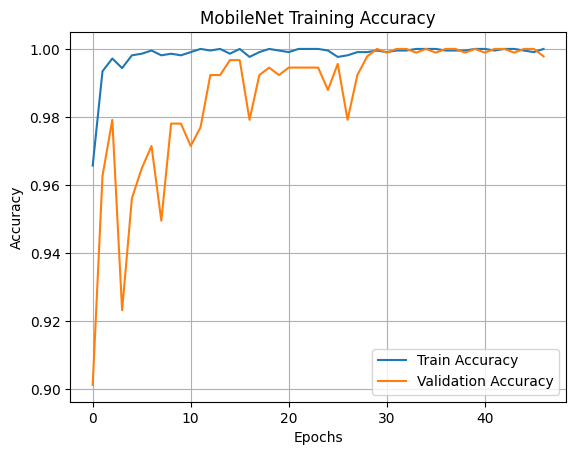

In [11]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNet Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

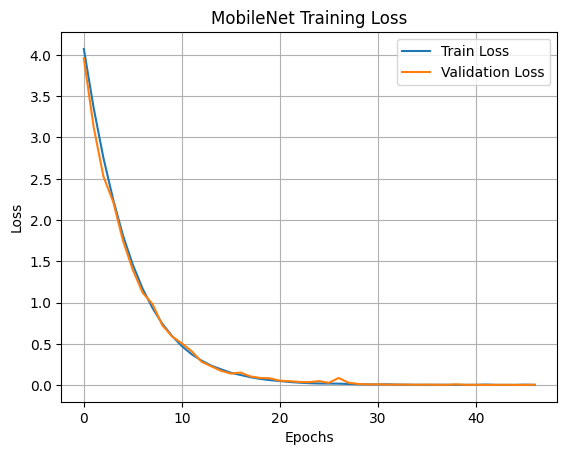

In [12]:
# Plot accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MobileNet Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save model
model.save('/content/drive/My Drive/ML1_Project/MobileNet/Model1/MobileNet_Model.h5')
print(">>> MobileNetV2 model saved successfully <<<")

>>> MobileNetV2 model saved successfully <<<
